In [ ]:
#@title Imports

import plotly.express as px
import pandas as pd
import numpy as np
import os

# Análise linguística
!python -m spacy download pt_core_news_sm
import spacy
nlp = spacy.load("pt_core_news_sm")
!pip install pyphen
import pyphen
nlp = spacy.load("pt_core_news_sm")
dic = pyphen.Pyphen(lang='pt_BR')

# Scikit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier

# DT
from sklearn import tree
import matplotlib.pyplot as plt

!git clone https://github.com/roneysco/Fake.br-Corpus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 30.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.2 MB/s eta 0:00:00
Cloning into 'Fake.br-Corpus'...
remote: Enumerating objects: 28763, done.
remote: Total 28763 (delta 0), reused 0 (delta 0), pack-reused 28763 (from 1)
Receiving objects: 100% (28763/28763), 37.10 MiB | 14.84 MiB/s, done.
Resolving deltas: 100% (14129/14129), done.
Updating files: 100% (21602/21602), done.


## **Fake.BR**

In [ ]:
#@title Extraindo os dados

fake_files = os.listdir('/content/Fake.br-Corpus/full_texts/fake')
true_files = os.listdir('/content/Fake.br-Corpus/full_texts/true')

df_fake = pd.DataFrame(columns = ['noticia', 'label'])
df_true = pd.DataFrame(columns = ['noticia', 'label'])

for files in fake_files:
  df_fake.loc[(len(df_fake))] = [open(os.path.join('/content/Fake.br-Corpus/full_texts/fake', files), 'r').read(), 1]

for files in true_files:
  df_true.loc[(len(df_true))] = [open(os.path.join('/content/Fake.br-Corpus/full_texts/true', files), 'r').read(), 0]

---

---
# **1. Extração de features linguísticos**

A fim de iniciar a análise exploratória, foram extraídos atributos textuais do corpo de texto das notícias. As métricas aqui calculadas se baseiam no artigo do NILC "*Sidney Evaldo Leal, Magali Sanches Duran, Carolina Evaristo Scarton, Nathan Siegle Hartmann, Sandra Maria Aluísio. NILC-Metrix: assessing the complexity of written and spoken language in Brazilian Portuguese. Lang Resources & Evaluation (2023)*" e avaliam características como inteligibilidade, complexidade textual, coesão e coerência. Todas as métricas foram adaptadas às nuances da língua portuguesa e foram implementadas à partir da biblioteca **spaCy**, própria para análise morfossintática.

---

#### **A seguir, uma breve descrição das métricas extraídas:**

**1. Type-token ratio**

Proporção de palavras sem repetições (types) em relação ao total de palavras com repetições (tokens).

**2. Number of sentences**

Número de sentenças.

**3. Size of sentences in words**

Tamanho médio das sentenças do enunciado.

**4. Verb-token ratio**

Proporção do número de verbos em relação ao número de tokens.

**5. Noun-token ratio**

Proporção do número de substantivos em relação ao número de tokens.

**6. Adjective-token ratio**

Proporção do número de adjetivos em relação ao número de tokens.

**7. Pronoun-token ratio**

Proporção do número de pronomes em relação ao número de tokens.

**8. Stopword-token ratio**

Proporção de stopwords (palavras que não carregam significado semântico) em relação ao número de tokens.

**9. Pausality**

Quantifica a presença de pausas ou interrupções na fluidez de um texto. Proporção de sinais de pontuação em relação ao total de tokens.

**10. Índice de Brunet**

Métrica de complexidade textual que avalia a proporção type-token de forma menos sensível ao tamanho de texto. Sua fórmula é descrita como:

$$
\text{Brunet's Index} = N^{V^{-0.165}}
$$

onde:
- \(N\) é o número total de palavras (tokens) no texto,
- \(V\) é o tamanho do vocabulário (número de palavras únicas).


\\

**11. Índice de gunning-fog**

O índice de inteligibilidade Gunning Fog soma a quantidade média de palavras por sentença ao percentual de palavras difíceis no texto e multiplica tudo por 0.4. O resultado está diretamente ligado aos 12 níveis do ensino americano. Índices superiores a 12 representam textos extremamente complexos.

**12. Especificidade**

Proporção de entidades nomeadas que pertencem a categorias semanticamente associadas a tempo e espaço.

**13. Informalidade**

Estimada pela proporção de erros de ortografia.

\\

[1] *LEAL, Sidney Evaldo; DURAN, Magali Sanches; SCARTON, Carolina Evaristo; HARTMANN, Nathan Siegle; ALUÍSIO, Sandra Maria. NILC-Metrix: assessing the complexity of written and spoken language in Brazilian Portuguese. 2021. Preprint. Disponível em: https://arxiv.org/abs/2201.03445.*

---

In [ ]:
from string import punctuation
#@title Funções refatoradas (otimizadas para o spacy)

nlp = spacy.load("pt_core_news_sm")
dic = pyphen.Pyphen(lang='pt_BR')
palavras_familiares = nlp.Defaults.stop_words

def contar_silabas(palavra):
    s = dic.inserted(palavra)
    return 1 if '-' not in s else len(s.split('-'))

def eh_palavra_dificil(token):
    if not token.is_alpha:
        return False
    if token.pos_ == "PROPN":
        return False
    if '-' in token.text:
        return False
    if token.text.lower() in palavras_familiares:
        return False
    return contar_silabas(token.text) >= 3

def contar_palavras_doc(doc):
    return sum(1 for t in doc if not t.is_space and not t.is_punct)

def contar_palavras_unicas_doc(doc):
    words_alpha_ling = [t.text.lower() for t in doc if t.is_alpha and not t.is_space and not t.is_punct]
    unique_words_ling = set(words_alpha_ling)
    return len(unique_words_ling)

def contar_verbos(tokens_ling):
    return sum(1 for t in tokens_ling if t.pos_ == "VERB")

def contar_substantivos(tokens_ling):
    return sum(1 for t in tokens_ling if t.pos_ in ("NOUN", "PROPN"))

def contar_adjetivos(tokens_ling):
    return sum(1 for t in tokens_ling if t.pos_ == "ADJ")

def contar_adverbios(tokens_ling):
    return sum(1 for t in tokens_ling if t.pos_ == "ADV")

def contar_pronome(tokens_ling):
    return sum(1 for t in tokens_ling if t.pos_ == "PRON")

def contar_stopwords(tokens_ling):
    return sum(1 for t in tokens_ling if t.is_stop)

def numero_de_sentencas_doc(doc):
    return len(list(doc.sents))

def palavras_por_sentenca_doc(doc):
    num_sent = numero_de_sentencas_doc(doc)
    total_tokens = contar_palavras_doc(doc)
    return total_tokens / num_sent if num_sent > 0 else 0

def contar_palavras_complexas(tokens_ling):
    return sum(1 for t in tokens_ling if eh_palavra_dificil(t))

def pausalidade_doc(num_punct, num_sentencas):
    """
    Razão entre sinais de pontuação e sentenças.
    """
    return num_punct / num_sentencas

def informalidade_doc(doc, total_palavras):
    return sum(1 for t in doc if t.is_oov) / total_palavras if total_palavras > 0 else 0

def proporcao_entidades_especificas(doc, total_palavras):
    tipos_especificos = {"DATE", "TIME", "GPE", "LOC", "CARDINAL", "ORDINAL"}
    ents_especificas = [ent for ent in doc.ents if ent.label_ in tipos_especificos]
    return len(ents_especificas) / total_palavras if total_palavras > 0 else 0

def contar_exclamacoes(doc):
    return sum(1 for t in doc if t.text == '!')

    # ------ Métricas ------
def extrair_metricas_otimizado(doc):
    """
    Recebe um objeto spaCy Doc e extrai as métricas de legibilidade/complexidade.
    É uma versão equivalente a 'extrair_metricas_completas',
    mas sem chamar nlp(texto)' dentro.
    """

    tokens = [t for t in doc if not t.is_space and not t.is_punct]
    tokens_with_punct = [t for t in doc]

    total_tokens_with_punct = len(tokens_with_punct)
    total_tokens = len(tokens)
    total_palavras = contar_palavras_doc(doc)

    num_sentences = numero_de_sentencas_doc(doc)
    punctuation = [t for t in doc if t.is_punct]
    total_punctuation = len(punctuation)

    # substitui "text, tokens_ling" pelas versões doc-based.
    n_type_token_ratio = (contar_palavras_unicas_doc(doc) / total_palavras) if total_palavras > 0 else 0
    size_of_sentences_in_words = (total_palavras / num_sentences) if num_sentences > 0 else 0
    n_verb_to_token_ratio = (contar_verbos(tokens) / total_tokens_with_punct) if total_tokens_with_punct > 0 else 0
    n_noun_to_token_ratio = (contar_substantivos(tokens) / total_tokens_with_punct) if total_tokens_with_punct > 0 else 0
    n_adjective_to_token_ratio = (contar_adjetivos(tokens) / total_tokens_with_punct) if total_tokens_with_punct > 0 else 0
    n_adverb_to_token_ratio = (contar_adverbios(tokens) / total_tokens_with_punct) if total_tokens_with_punct > 0 else 0
    n_pronoun_to_token_ratio = (contar_pronome(tokens) / total_tokens_with_punct) if total_tokens_with_punct > 0 else 0
    n_stopword_to_token_ratio = (contar_stopwords(tokens) / total_tokens_with_punct) if total_tokens_with_punct > 0 else 0
    pausality = pausalidade_doc(len(punctuation), num_sentences)
    tokens_per_sentence = palavras_por_sentenca_doc(doc)

    # complexidade
    total_silabas = sum(contar_silabas(t.text) for t in tokens)
    media_silabas_palavra = (total_silabas / total_palavras) if total_palavras > 0 else 0
    num_palavras_complexas_ = contar_palavras_complexas(tokens)
    percentual_palavras_complexas_ = (num_palavras_complexas_ / total_palavras) * 100 if total_palavras > 0 else 0

    gunning_fog_ = 0
    if total_palavras > 0 and num_sentences > 0:
        gunning_fog_ = 0.4 * (tokens_per_sentence + (percentual_palavras_complexas_ / 100))

    vocab_palavras = set(t.text.lower() for t in tokens if t.is_alpha)
    vocab_size = len(vocab_palavras)
    brunet_ = 0
    if total_palavras > 0:
        brunet_ = total_palavras ** (vocab_size ** (-0.165))


    # psicolinguística
    informalidade = informalidade_doc(doc, total_palavras)
    especificidade = proporcao_entidades_especificas(doc, total_palavras)
    numero_de_exclamacoes = contar_exclamacoes(doc)

    # ------ dicionário ------
    return {
        "type_token_ratio": n_type_token_ratio,
        "number_of_sentences": num_sentences,
        "size_of_sentences_in_words": size_of_sentences_in_words,
        "verb_to_token_ratio": n_verb_to_token_ratio,
        "noun_to_token_ratio": n_noun_to_token_ratio,
        "adjective_to_token_ratio": n_adjective_to_token_ratio,
        "adverb_to_token_ratio": n_adverb_to_token_ratio,
        "pronoun_to_token_ratio": n_pronoun_to_token_ratio,
        "stopword_to_token_ratio": n_stopword_to_token_ratio,
        "pausality": pausality,
        "num_palavras": total_palavras,
        "num_tokens": len(tokens_with_punct),
        "num_sentencas": num_sentences,
        "media_tokens_sentenca": tokens_per_sentence,
        "total_silabas": total_silabas,
        "media_silabas_palavra": media_silabas_palavra,
        "num_palavras": total_palavras,
        "num_palavras_complexas": num_palavras_complexas_,
        "percentual_palavras_complexas": percentual_palavras_complexas_,
        "gunning_fog": gunning_fog_,
        "brunet": brunet_,
        "informalidade": informalidade,
        "especificidade": especificidade,
        "numero_de_exclamacoes": numero_de_exclamacoes
    }

In [ ]:
#@title Extração otimizada

fake_texts = df_fake['noticia'].tolist()
docs_fake = nlp.pipe(fake_texts, batch_size=32, n_process=1)
results_fake = [extrair_metricas_otimizado(doc) for doc in docs_fake]
df_fake_class = pd.DataFrame(results_fake)
df_fake_class["label"] = 1

true_texts = df_true['noticia'].tolist()
docs_true = nlp.pipe(true_texts, batch_size=32, n_process=1)
results_true = [extrair_metricas_otimizado(doc) for doc in docs_true]
df_true_class = pd.DataFrame(results_true)
df_true_class["label"] = 0

df_metrics = pd.concat([df_fake_class, df_true_class])

---

## **Decision Tree para extrair as melhores regras**

In [ ]:
#@title Decision tree

df_metrics.drop('num_tokens', axis=1, inplace=True)

train, test = train_test_split(df_metrics, test_size=0.2, random_state=0)

X_train = train.drop('label', axis=1)
y_train = train['label']
X_test = test.drop('label', axis=1)
y_test = test['label']

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       729
           1       0.93      0.93      0.93       711

    accuracy                           0.93      1440
   macro avg       0.93      0.93      0.93      1440
weighted avg       0.93      0.93      0.93      1440



[Text(0.5, 0.875, 'total_silabas <= 789.0\ngini = 0.5\nsamples = 5760\nvalue = [2871, 2889]'),
 Text(0.25, 0.625, 'brunet <= 11.837\ngini = 0.122\nsamples = 2943\nvalue = [192.0, 2751.0]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'brunet <= 11.2\ngini = 0.069\nsamples = 2723\nvalue = [97, 2626]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'informalidade <= 1.205\ngini = 0.491\nsamples = 220\nvalue = [95.0, 125.0]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'total_silabas <= 1137.5\ngini = 0.093\nsamples = 2817\nvalue = [2679, 138]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'type_token_ratio <= 0.524\ngini = 0.371\nsamples = 402\nvalue = [303, 99]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'pausality <= 1.554\ngini = 0.032\nsamples = 2415\nvalue = [2376, 39]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),

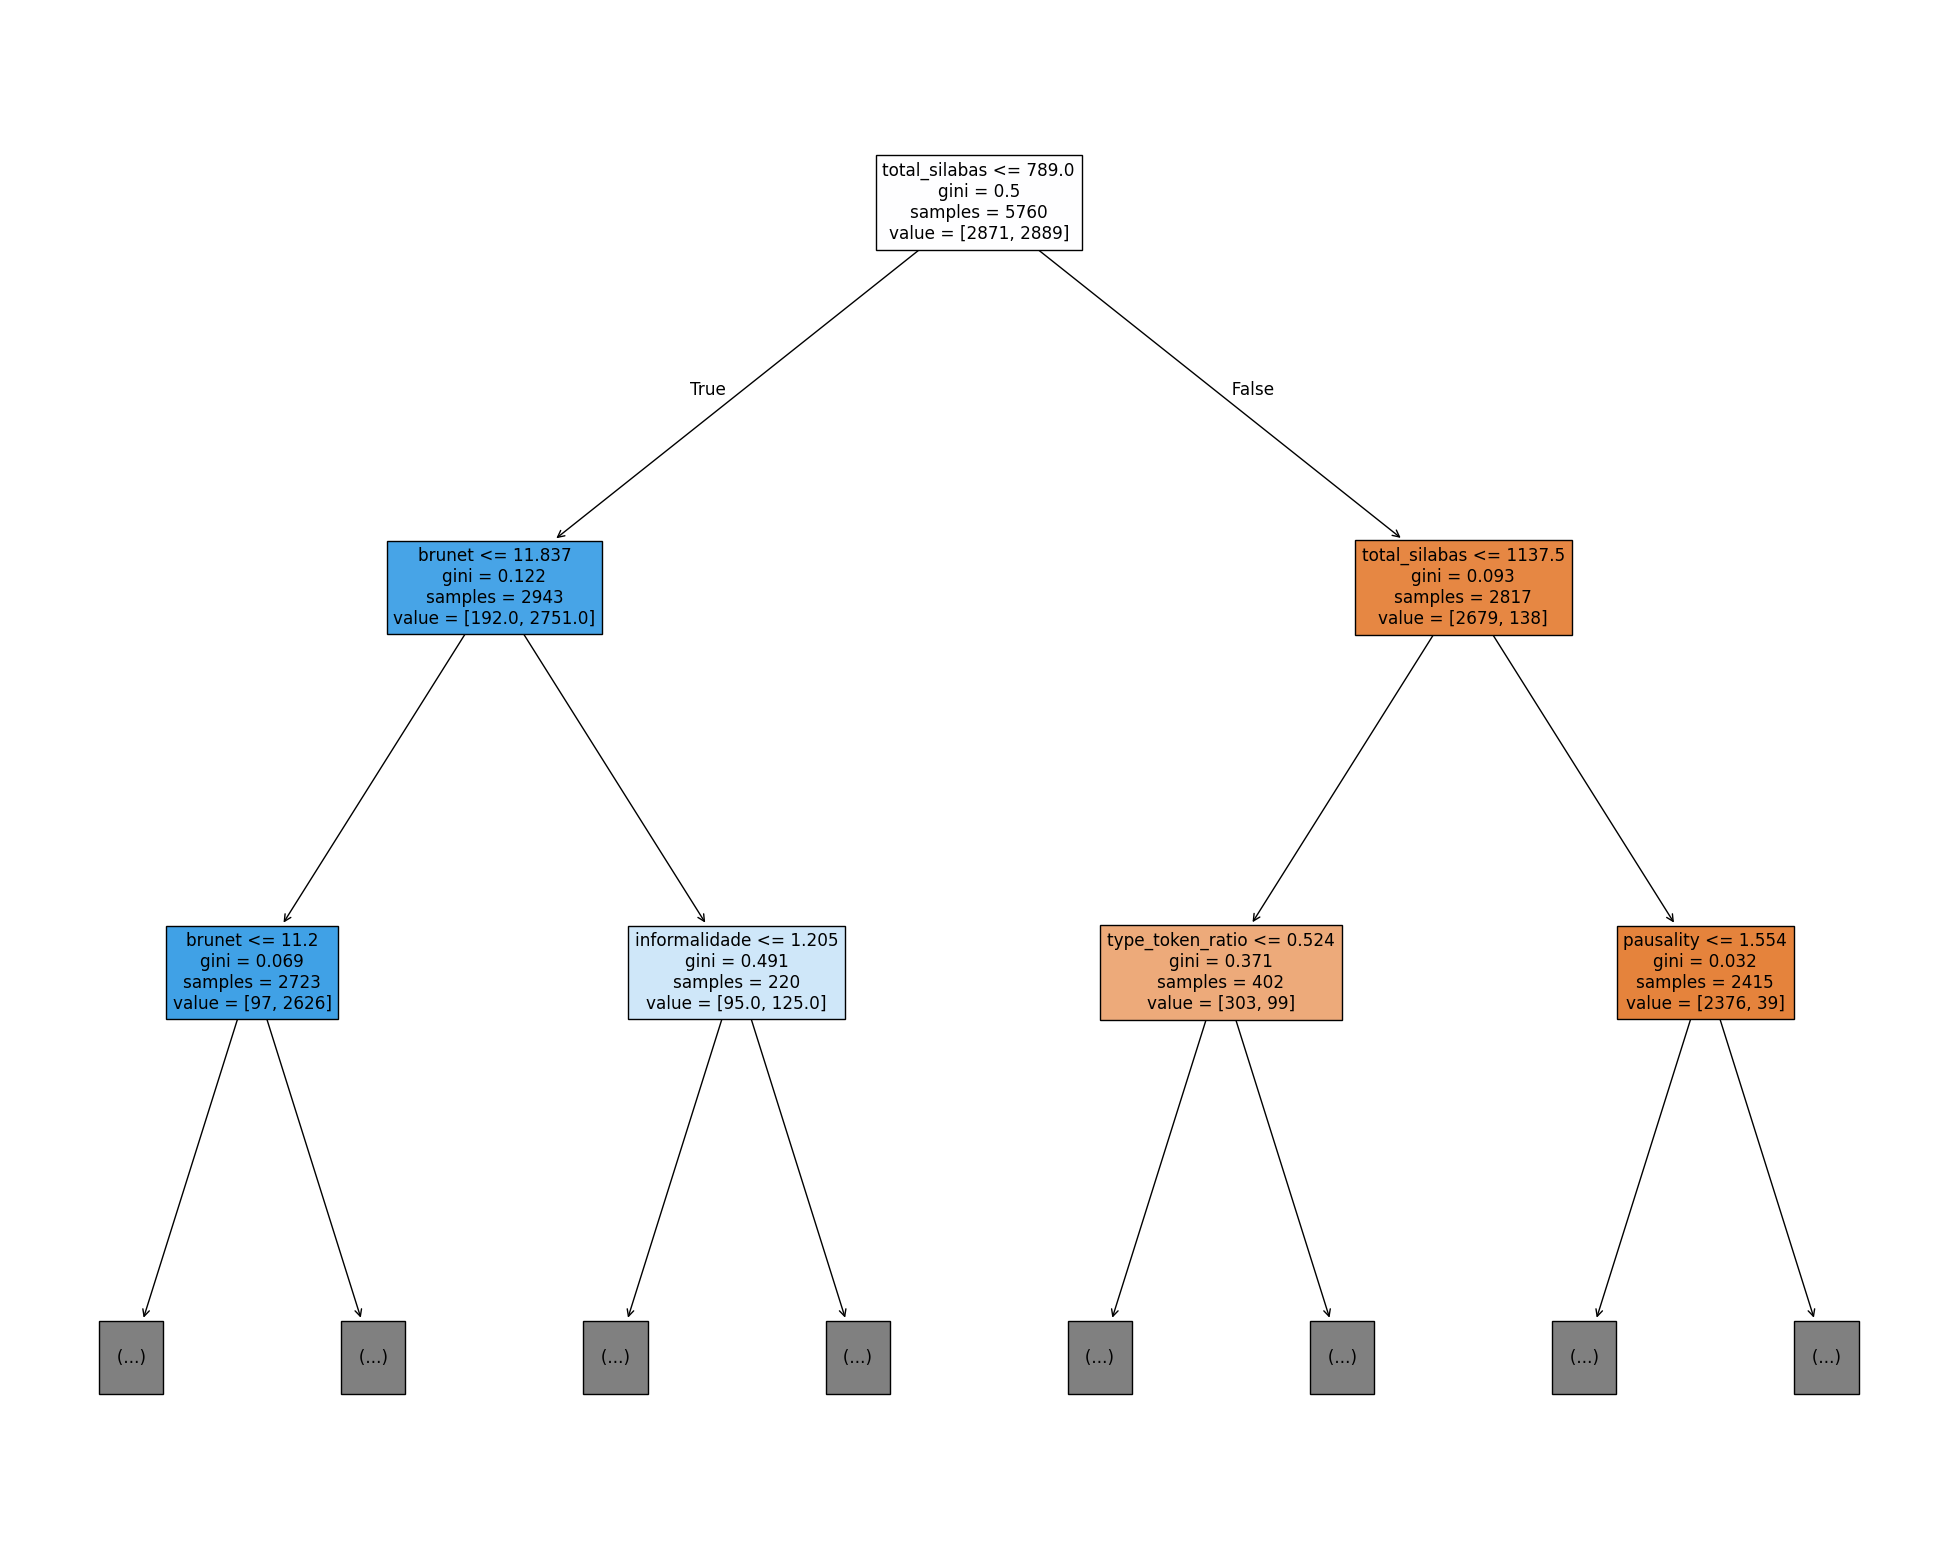

In [ ]:
#@title Visualizando árvore

fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf, feature_names=X_train.columns, filled=True, max_depth = 2)

In [ ]:
#@title Regras pela DT

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)

print(classification_report(y_test, pred))

rules_text = export_text(dt, feature_names=X_train.columns)
print(rules_text)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       729
           1       0.94      0.96      0.95       711

    accuracy                           0.95      1440
   macro avg       0.95      0.95      0.95      1440
weighted avg       0.95      0.95      0.95      1440

|--- total_silabas <= 789.00
|   |--- brunet <= 11.84
|   |   |--- class: 1
|   |--- brunet >  11.84
|   |   |--- class: 1
|--- total_silabas >  789.00
|   |--- total_silabas <= 1137.50
|   |   |--- class: 0
|   |--- total_silabas >  1137.50
|   |   |--- class: 0



---

## **Distribuições**

In [ ]:
#@title Import Dash

!pip install dash

import dash
from dash import dcc, html
from dash.dependencies import Input, Output

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 131.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
#@title Dash distribuições

COLUNA_LABEL = 'label'
colunas = df_metrics.columns.tolist()
colunas.remove(COLUNA_LABEL)

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Boxplot"),
    dcc.Dropdown(
        id='coluna-dropdown',
        options=[{'label': col, 'value': col} for col in colunas],
        value=colunas[0],
        clearable=False,
        style={'width': '300px'}
    ),

    dcc.Graph(id='boxplot-graph')
])

@app.callback(
    Output('boxplot-graph', 'figure'),
    Input('coluna-dropdown', 'value')
)
def atualizar_boxplot(coluna_escolhida):
    fig = px.box(
        df_metrics,
        x=COLUNA_LABEL,
        y=coluna_escolhida,
        color=COLUNA_LABEL,
        color_discrete_map={0: "blue", 1: "red"},
        labels={COLUNA_LABEL: "Classe", coluna_escolhida: coluna_escolhida},
        title=f"Distribuição da coluna '{coluna_escolhida}' por classe"
    )
    return fig

if __name__ == "__main__":
    app.run()

<IPython.core.display.Javascript object>

In [ ]:
#@title Médias

mean = df_metrics.groupby("label").mean()
mean_t = mean.T

print(mean_t.to_markdown(floatfmt=".2f"))

|                               |       0 |      1 |
|:------------------------------|--------:|-------:|
| type_token_ratio              |    0.43 |   0.63 |
| number_of_sentences           |   62.87 |  13.20 |
| size_of_sentences_in_words    |   18.57 |  14.39 |
| verb_to_token_ratio           |    0.10 |   0.11 |
| noun_to_token_ratio           |    0.29 |   0.28 |
| adjective_to_token_ratio      |    0.04 |   0.04 |
| adverb_to_token_ratio         |    0.03 |   0.04 |
| pronoun_to_token_ratio        |    0.03 |   0.03 |
| stopword_to_token_ratio       |    0.42 |   0.38 |
| pausality                     |    2.89 |   2.43 |
| num_palavras                  | 1094.62 | 184.06 |
| num_sentencas                 |   62.87 |  13.20 |
| media_tokens_sentenca         |   18.57 |  14.39 |
| total_silabas                 | 2240.90 | 373.75 |
| media_silabas_palavra         |    2.05 |   2.03 |
| num_palavras_complexas        |  266.77 |  43.59 |
| percentual_palavras_complexas |   24.35 |  2

---
## **Truncamento do Dataset**

"To ensure that traditional classification models and BERT did
not rely on the length of the text as a distinguishing factor,
all texts were truncated to 200 tokens, following Silva et al.
[2020]. This prevents the models from exploiting length differences between true and fake news — an issue that could be
easily bypassed by deliberately adjusting the article length"

In [ ]:
#@title Truncamento do Dataset para 200 tokens

def truncar_para_200_tokens(texto, limite=200):
    doc = nlp.make_doc(texto)
    tokens_truncados = doc[:limite]
    return " ".join([token.text for token in tokens_truncados])

def truncar_dataframe(df, coluna_texto="noticia", limite=200):
    df_truncado = df.copy()
    df_truncado[f"{coluna_texto}_truncado"] = df_truncado[coluna_texto].apply(lambda x: truncar_para_200_tokens(x, limite))
    return df_truncado

df = pd.concat([df_fake, df_true])
df_truncado = truncar_dataframe(df)

In [ ]:
#@title Métricas no dataframe truncado

truncated_texts = df_truncado['noticia_truncado'].tolist()

nlp_truncado = nlp.pipe(truncated_texts, batch_size=128, n_process=1)
results = [extrair_metricas_otimizado(doc) for doc in nlp_truncado]
df_metrics_truncado = pd.DataFrame(results)
df_truncado = df_truncado.reset_index(drop=True)
df_metrics_truncado["label"] = df_truncado["label"]
df_metrics_truncado

,type_token_ratio,number_of_sentences,size_of_sentences_in_words,verb_to_token_ratio,noun_to_token_ratio,adjective_to_token_ratio,adverb_to_token_ratio,pronoun_to_token_ratio,stopword_to_token_ratio,pausality,...,total_silabas,media_silabas_palavra,num_palavras_complexas,percentual_palavras_complexas,gunning_fog,brunet,informalidade,especificidade,numero_de_exclamacoes,label
0,0.643750,15,10.666667,0.090909,0.277778,0.035354,0.030303,0.030303,0.409091,1.800000,...,337,2.106250,42,26.250000,4.371667,10.615208,1.237500,0.025000,0,1
1,0.681564,8,22.375000,0.115000,0.325000,0.025000,0.030000,0.045000,0.445000,2.125000,...,348,1.944134,34,18.994413,9.025978,10.464681,1.117318,0.027933,0,1
2,0.722892,7,11.857143,0.078431,0.392157,0.029412,0.019608,0.009804,0.352941,1.857143,...,184,2.216867,23,27.710843,4.853701,9.474520,1.228916,0.048193,0,1
3,0.714286,3,28.000000,0.122642,0.216981,0.066038,0.075472,0.056604,0.367925,5.666667,...,171,2.035714,18,21.428571,11.285714,9.532437,1.261905,0.000000,0,1
4,0.656566,6,16.500000,0.102564,0.273504,0.034188,0.042735,0.008547,0.435897,2.500000,...,184,1.858586,22,22.222222,6.688889,10.050575,1.181818,0.040404,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.602339,9,19.000000,0.095000,0.325000,0.040000,0.025000,0.010000,0.420000,2.555556,...,354,2.070175,47,27.485380,7.709942,10.948866,1.169591,0.052632,0,0
7196,0.674157,10,17.800000,0.095000,0.310000,0.050000,0.035000,0.030000,0.400000,2.100000,...,373,2.095506,46,25.842697,7.223371,10.505256,1.123596,0.022472,0,0
7197,0.525140,12,14.916667,0.100000,0.335000,0.010000,0.035000,0.025000,0.445000,1.666667,...,371,2.072626,46,25.698324,6.069460,11.602504,1.117318,0.000000,0,0
7198,0.610465,7,24.571429,0.090000,0.290000,0.030000,0.065000,0.055000,0.415000,3.857143,...,329,1.912791,34,19.767442,9.907641,10.895602,1.162791,0.023256,0,0


In [ ]:
#@title Médias

mean = df_metrics_truncado.groupby("label").mean()
mean_t = mean.T

print(mean_t.to_markdown(floatfmt=".2f"))

|                               |      0 |      1 |
|:------------------------------|-------:|-------:|
| type_token_ratio              |   0.60 |   0.65 |
| number_of_sentences           |   9.79 |  10.23 |
| size_of_sentences_in_words    |  18.68 |  14.25 |
| verb_to_token_ratio           |   0.10 |   0.11 |
| noun_to_token_ratio           |   0.32 |   0.29 |
| adjective_to_token_ratio      |   0.04 |   0.04 |
| adverb_to_token_ratio         |   0.03 |   0.03 |
| pronoun_to_token_ratio        |   0.03 |   0.03 |
| stopword_to_token_ratio       |   0.40 |   0.38 |
| pausality                     |   2.78 |   2.39 |
| num_palavras                  | 172.13 | 137.49 |
| num_tokens                    | 199.68 | 166.18 |
| num_sentencas                 |   9.79 |  10.23 |
| media_tokens_sentenca         |  18.68 |  14.25 |
| total_silabas                 | 355.38 | 279.72 |
| media_silabas_palavra         |   2.06 |   2.03 |
| num_palavras_complexas        |  40.75 |  32.51 |
| percentual

In [ ]:
#@title Decision tree invariante ao tamanho de texto


train, test = train_test_split(df_metrics_truncado, test_size=0.2, random_state=0)

X_train = train.drop('label', axis=1)
y_train = train['label']
X_test = test.drop('label', axis=1)
y_test = test['label']

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       729
           1       0.83      0.84      0.84       711

    accuracy                           0.84      1440
   macro avg       0.84      0.84      0.84      1440
weighted avg       0.84      0.84      0.84      1440



In [ ]:
#@title Regras pela DT

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)

print(classification_report(y_test, pred))

rules_text = export_text(dt, feature_names=X_train.columns)
print(rules_text)

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       729
           1       0.90      0.68      0.77       711

    accuracy                           0.80      1440
   macro avg       0.82      0.80      0.80      1440
weighted avg       0.82      0.80      0.80      1440

|--- num_palavras <= 163.50
|   |--- num_tokens <= 198.50
|   |   |--- class: 1
|   |--- num_tokens >  198.50
|   |   |--- class: 1
|--- num_palavras >  163.50
|   |--- num_palavras <= 168.50
|   |   |--- class: 0
|   |--- num_palavras >  168.50
|   |   |--- class: 0



In [ ]:
#@title Regras que excluem a contagem de palavras

X_train.drop('num_palavras', axis=1, inplace=True)
X_test.drop('num_palavras', axis=1, inplace=True)

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)

print(classification_report(y_test, pred))

rules_text = export_text(dt, feature_names=X_train.columns)
print(rules_text)

              precision    recall  f1-score   support

           0       0.78      0.85      0.82       729
           1       0.83      0.76      0.79       711

    accuracy                           0.80      1440
   macro avg       0.81      0.80      0.80      1440
weighted avg       0.81      0.80      0.80      1440

|--- num_tokens <= 199.50
|   |--- brunet <= 11.26
|   |   |--- class: 1
|   |--- brunet >  11.26
|   |   |--- class: 1
|--- num_tokens >  199.50
|   |--- informalidade <= 1.20
|   |   |--- class: 0
|   |--- informalidade >  1.20
|   |   |--- class: 1



---

## **Removendo métricas baseadas em tamanho de texto**

In [ ]:
X_train.columns

Index(['type_token_ratio', 'size_of_sentences_in_words', 'verb_to_token_ratio',
       'noun_to_token_ratio', 'adjective_to_token_ratio',
       'adverb_to_token_ratio', 'pronoun_to_token_ratio',
       'stopword_to_token_ratio', 'pausality', 'num_tokens', 'num_sentencas',
       'media_tokens_sentenca', 'total_silabas', 'media_silabas_palavra',
       'num_palavras_complexas', 'percentual_palavras_complexas',
       'gunning_fog', 'brunet', 'informalidade', 'especificidade',
       'numero_de_exclamacoes'],
      dtype='object')

In [ ]:
train, test = train_test_split(df_metrics_truncado, test_size=0.2, random_state=0)

X_train = train.drop(['num_palavras', 'number_of_sentences', 'num_tokens', 'num_sentencas', 'total_silabas', 'num_palavras_complexas', 'label'], axis=1)
y_train = train['label']
X_test = test.drop(['num_palavras', 'number_of_sentences', 'num_tokens', 'num_sentencas', 'total_silabas', 'num_palavras_complexas', 'label'], axis=1)
y_test = test['label']

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)

print(classification_report(y_test, pred))

rules_text = export_text(dt, feature_names=X_train.columns)
print(rules_text)

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       729
           1       0.75      0.71      0.73       711

    accuracy                           0.74      1440
   macro avg       0.74      0.74      0.74      1440
weighted avg       0.74      0.74      0.74      1440

|--- informalidade <= 1.18
|   |--- brunet <= 10.21
|   |   |--- class: 1
|   |--- brunet >  10.21
|   |   |--- class: 0
|--- informalidade >  1.18
|   |--- pausality <= 2.81
|   |   |--- class: 1
|   |--- pausality >  2.81
|   |   |--- class: 1



In [ ]:
#@title Tabela pistas linguísticas

from IPython.display import Markdown

tabela_markdown = """
| **Construtor**     | **Pista linguística**                                                                 | **Comportamento esperado em conteúdo enganoso** | **Trabalhos relacionados**                   |
|--------------------|----------------------------------------------------------------------------------------|:------------------------------------------------:|-----------------------------------------------|
| Quantidade         | Avg number of sentences per text - #p1  <br> Avg number of verbs - #p2                 | +                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Complexidade       | Avg size of words - #p3  <br> Avg pausality - #p4  <br> Avg number of sentences (in words) - #p5 | -                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Não imediatismo    | Avg number of modal verbs - #p6  <br> Avg self reference (1st person pronoun) - #p7 <br> Avg group reference (2nd person pronoun) - #p8 <br> Avg another reference (3rd person pronoun) - #p9 | + / - / + / +                                    | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Expressividade     | Avg emotiveness - #p10                                                                 | +                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Afeto              | Positive affect - #p11  <br> Negative affect - #p12                                    | +                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Especificidade     | Avg spatiotemporal words - #p13                                                        | -                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Diversidade        | Avg lexical diversity - #p14  <br> Avg number of types per text - #p15                 | -                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Informalidade      | Avg misspelled words - #p16                                                            | +                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Punctuation Cue    | Average number of exclamation marks - #p17                                            | +                                                | Fernandez and Devaraj (2019)                 |
"""

Markdown(tabela_markdown)


| **Construtor**     | **Pista linguística**                                                                 | **Comportamento esperado em conteúdo enganoso** | **Trabalhos relacionados**                   |
|--------------------|----------------------------------------------------------------------------------------|:------------------------------------------------:|-----------------------------------------------|
| Quantidade         | Avg number of sentences per text - #p1  <br> Avg number of verbs - #p2                 | +                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Complexidade       | Avg size of words - #p3  <br> Avg pausality - #p4  <br> Avg number of sentences (in words) - #p5 | -                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Não imediatismo    | Avg number of modal verbs - #p6  <br> Avg self reference (1st person pronoun) - #p7 <br> Avg group reference (2nd person pronoun) - #p8 <br> Avg another reference (3rd person pronoun) - #p9 | + / - / + / +                                    | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Expressividade     | Avg emotiveness - #p10                                                                 | +                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Afeto              | Positive affect - #p11  <br> Negative affect - #p12                                    | +                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Especificidade     | Avg spatiotemporal words - #p13                                                        | -                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Diversidade        | Avg lexical diversity - #p14  <br> Avg number of types per text - #p15                 | -                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Informalidade      | Avg misspelled words - #p16                                                            | +                                                | Zhou and Zhang (2008), Fuller et al. (2006), Zhou et al. (2003) |
| Punctuation Cue    | Average number of exclamation marks - #p17                                            | +                                                | Fernandez and Devaraj (2019)                 |
